In [3]:
from jia_sims import *

In [15]:
feature_description = {
    'field': tf.FixedLenFeature([2**16], tf.float32),
    "params": tf.FixedLenFeature([3], tf.float32)
}

data_path = lambda x: ["/global/scratch/avirukt/jia_sims/%s/%04d.tfrecord"%(x,i) for i in range(10000)]

def parse(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    d = tf.parse_single_example(example_proto, feature_description)
    return (tf.reshape(d["field"],(256,256)),d["params"])

def dataset(version):
    d = tf.data.TFRecordDataset(data_path(version), buffer_size=int(1.2*256**2*4))
    if "random_mask" in version:
        d = d.map(parse_with_mask)
    else:
        d = d.map(parse)
    return d. make_one_shot_iterator()

def plot_images(versions,figsize=10):
    n = len(versions)
    datasets = [dataset(v) for v in versions]
    while True:
        data = [next(d) for d in datasets]
        params = data[0][1].numpy()
        print(params)
        for i in range(1,n):
            if any(data[i][1].numpy() != params):
                print("whoopsie %d"%i)
        f,ax = subplots(1, n, sharex=True, sharey=True, figsize=(n*figsize,figsize+1))
        for i in range(n):
            im = data[i][0].numpy()
            ax[i].set_title(versions[i])
            ax[i].imshow(im, cmap=cm.viridis)
            print(versions[i],amax(abs(im)))
        yield

In [16]:
v1 = ["noiseless", "noisy"]
v2 = ["","gaussian","whitened","descaled"]
versions = []
for i in v1:
    for j in v2:
        v = i
        if j:
            v+= "_"+j
        versions.append(v)
versions

['noiseless',
 'noiseless_gaussian',
 'noiseless_whitened',
 'noiseless_descaled',
 'noisy',
 'noisy_gaussian',
 'noisy_whitened',
 'noisy_descaled']

In [17]:
images = plot_images(versions)

[0.08788 0.2926  0.7429 ]
noiseless 0.14093946
noiseless_gaussian 0.0508143
noiseless_whitened 19.182804
noiseless_descaled 0.27778354
noisy 0.56406087
noisy_gaussian 0.5181379
noisy_whitened 4.599495
noisy_descaled 0.103411324


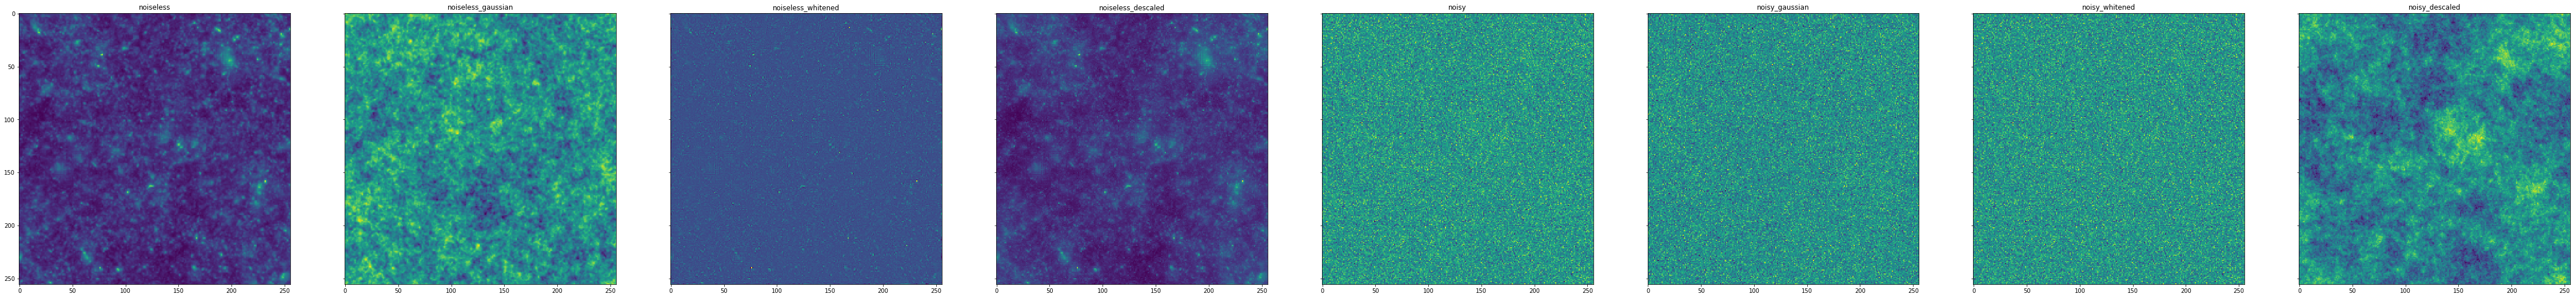

In [29]:
next(images)

In [10]:
def compare_ps(versions):
    n = len(versions)
    datasets = [dataset(v) for v in versions]
    while True:
        for i in range(n):
            loglog(*dynamic_ps(next(datasets[i])[0].numpy())[:2], label=versions[i])
        legend(frameon=False)
        yield

spectra = compare_ps(versions)

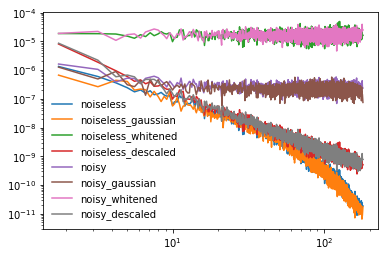

In [11]:
next(spectra)

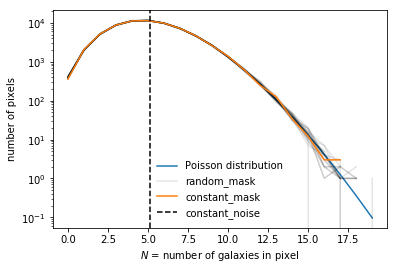

In [202]:
from scipy.stats import poisson
plot(2**16*poisson.pmf(arange(20),5.12),label="Poisson distribution")

d = dataset("random_mask")
n=20
plot(bincount(next(d)[2].numpy().astype(int).flatten()),alpha=0.1,label="random_mask",c="k")
for i in range(n):
    plot(bincount(next(d)[2].numpy().astype(int).flatten()),alpha=0.1,c="k")
    
mask = load("/global/scratch/avirukt/jia_sims/constant_mask/mask.npy")
plot(bincount(mask.flatten()),label="constant_mask")

axvline(mean(mask),c="k",ls="--",label="constant_noise")

xlabel("$N$ = number of galaxies in pixel")
ylabel("number of pixels")
legend(frameon=False)
yscale("log")

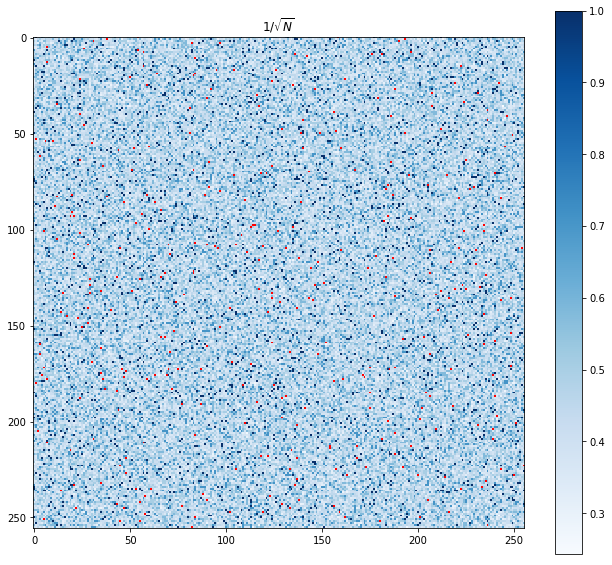

In [155]:
figure(figsize=(11,10))
title(r"$1/\sqrt{N}$")
cmap = cm.Blues
cmap.set_bad('red',1.)
imshow(1/sqrt(mask), cmap=cmap)
colorbar()

In [178]:
versions = ["noiseless","constant_noise","constant_mask","random_mask"]
plots = plot_data(versions)

[0.07024 0.2023  0.6231 ]


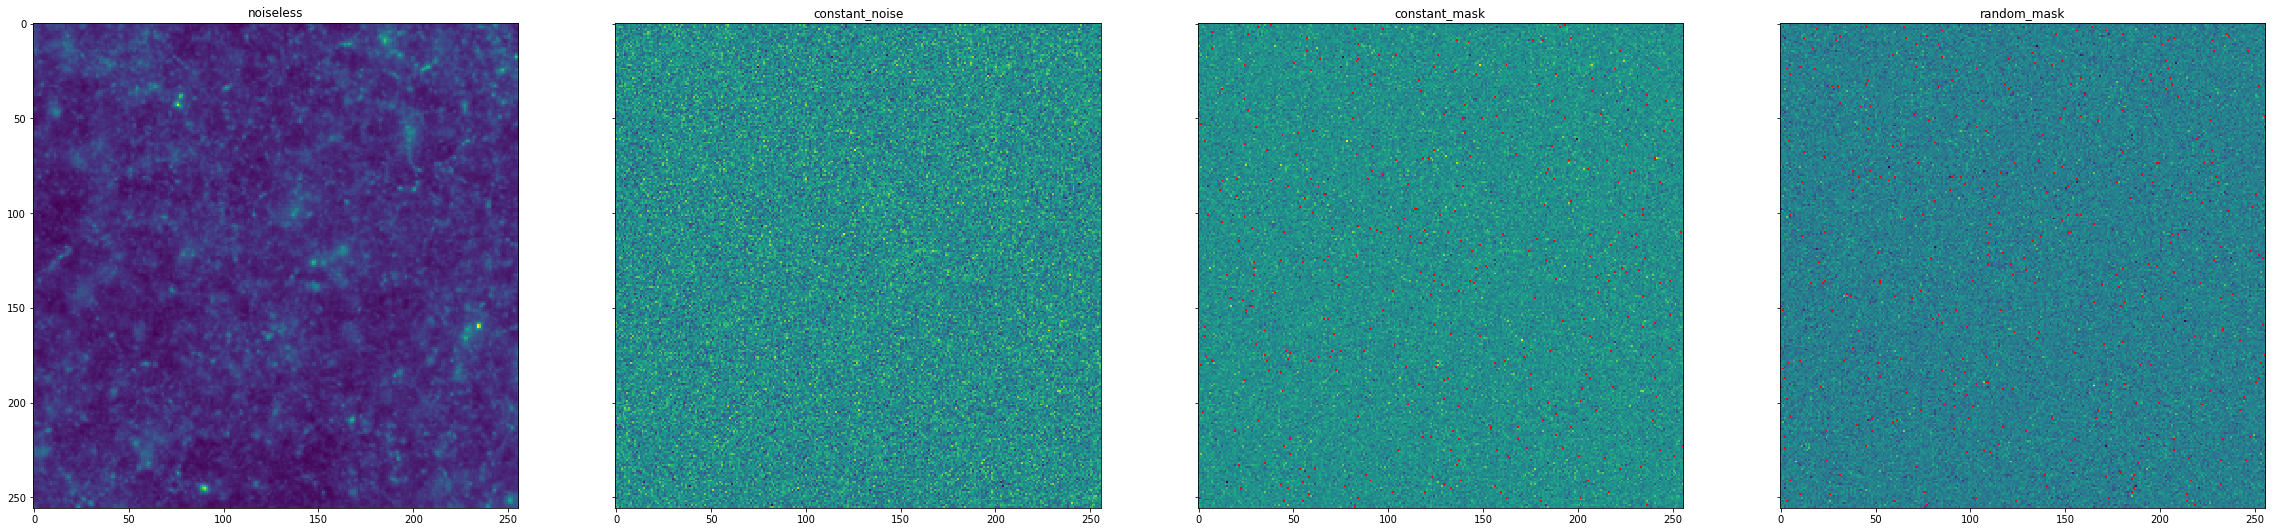

In [203]:
next(plots)

In [30]:
next(datasets[1])[1].numpy()

array([0.    , 0.3   , 0.8523], dtype=float32)

In [183]:
d = dataset("random_mask")

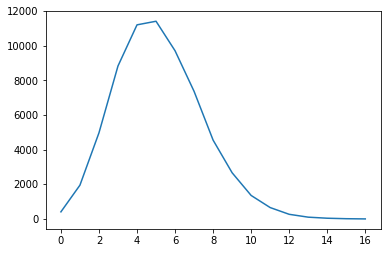

In [192]:
plot(bincount(next(d)[2].numpy().astype(int).flatten()))

Text(0.5, 1.0, 'random mask')

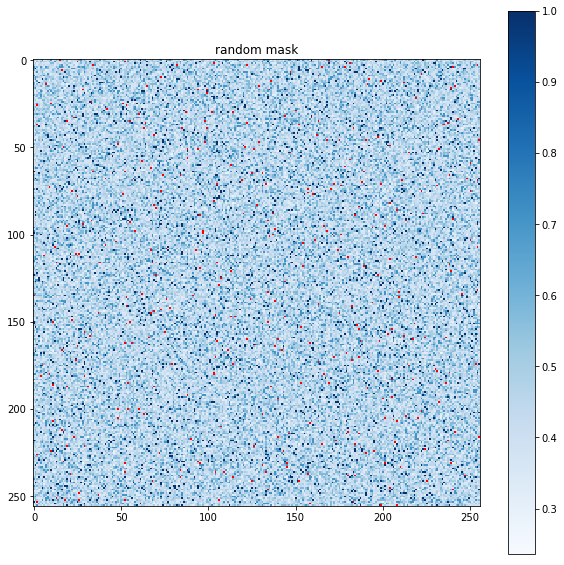

In [191]:
figure(figsize=(10,10))
imshow(1/sqrt(next(d)[2].numpy()),cmap=cmap)
colorbar()
title("random mask")

In [30]:
bounds = [0.2,0.2,100,5,10,10,30,2]
directories = ["/global/scratch/avirukt/jia_sims/%s/"%v for v in versions]
n = len(versions)
nbins = 10**4

In [ ]:
from tqdm_sucks import tqdm

for i in range(3,n):
    version = versions[i]
    print("Starting %s"%version)
    b = (-bounds[i],bounds[i])
    counts = 0
    s = 0
    s2 = 0
    for elem in tqdm(dataset(version),101*10**4):
        field = elem[0].numpy()
        counts += histogram(field,range=b,bins=nbins)[0]
        s += field
        s2 += field**2
    save(directories[i]+"counts.npy",counts)
    save(directories[i]+"sum.npy",s)
    save(directories[i]+"squared_sum.npy",s2)

Starting noiseless_descaled
983239/1010000~97.4%, 45 minutes 47 seconds so far, 1 minute 14 seconds longerrr

In [ ]:
from tqdm_sucks import tqdm

pixels = []

for i,elem in enumerate(tqdm(dataset("noiseless"),101*10**4)):
    field = abs(elem[0].numpy())>0.2
    if field.any():
        pixels.append((i,field))

471896/1010000~46.7%, 26 minutes 43 seconds so far, 30 minutes 28 seconds longer

In [ ]:
pixels

-5.437087059760111e-06 0.015977563570403572 0.015977562645296425
-1.6453118577168409e-12 0.014669594470540873 0.014669594470540873
-8.629780753618171e-11 1.0593686088664025 1.0593686088664025


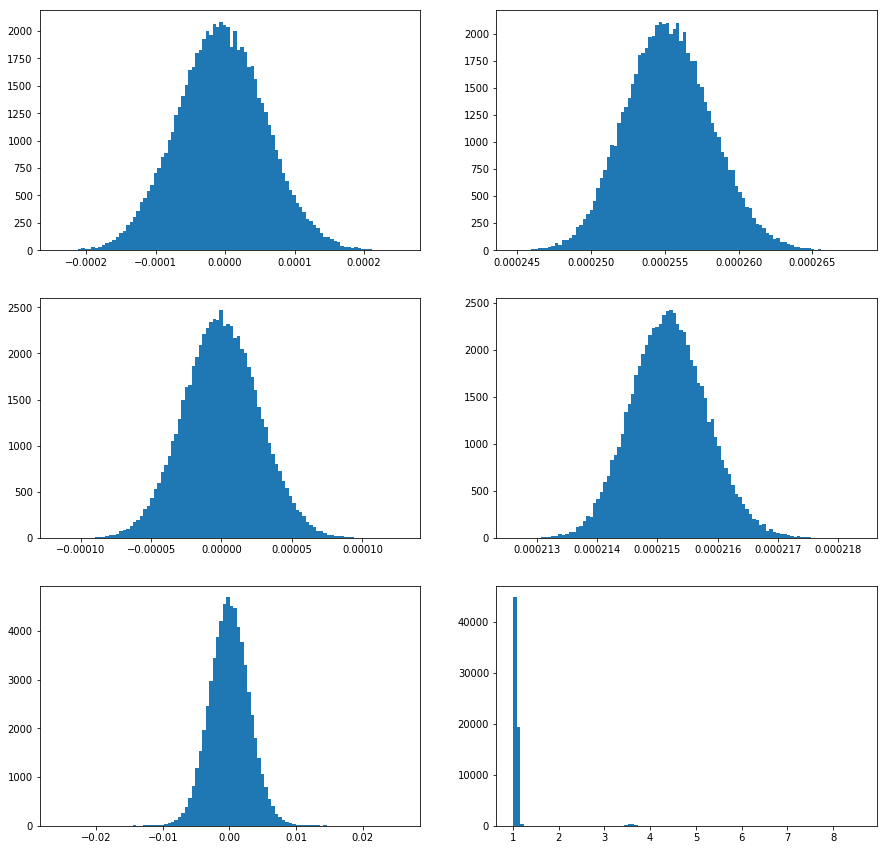

In [10]:
N = 10**4*101
f,ax = subplots(3,2,figsize=(15,15))
for i in range(n):
    counts = load(directories[i]+"counts.npy")
    edges = linspace(-bounds[i],bounds[i],nbins)
    #ax[i,0].plot(edges,counts)
    m = load(directories[i]+"sum.npy")/N
    ax[i,0].hist(m.flatten(),bins=100)
    s2 = load(directories[i]+"squared_sum.npy")/N
    s = sqrt(s2-m**2)
    ax[i,1].hist(s2.flatten(),bins=100)
    m = mean(m)
    s = sqrt(mean(s2))
    s3 = sqrt(mean(s2)-m**2)
    print(m,s,s3)

noiseless 5800050
noiseless_gaussian 0
noiseless_whitened 0


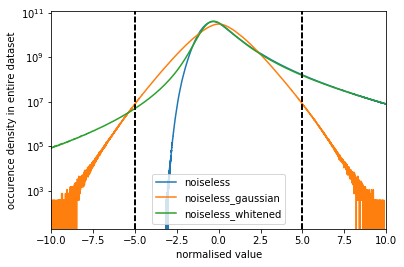

In [35]:
arbitrary_cutoff = 5

for i in range(n):
    counts = load(directories[i]+"counts.npy")
    s2 = mean(load(directories[i]+"squared_sum.npy")/N)**.5
    edges = linspace(-bounds[i],bounds[i],nbins)/s2
    plot(edges,counts/(edges[1]-edges[0]),label=versions[i])
    legend()
    print(versions[i],101*10**4*256**2-sum(counts))
    xlim(-10,10)
    yscale("log")
    xlabel("normalised value")
    ylabel("occurence density in entire dataset")
    axvline(arbitrary_cutoff, c="k", ls="--")
    axvline(-arbitrary_cutoff, c="k", ls="--")

total number of pixels: 6.6e+10


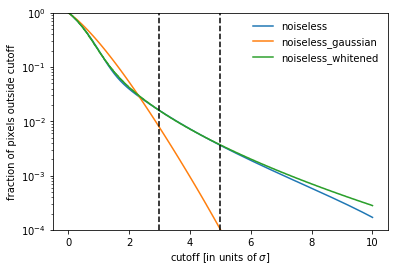

In [54]:
cutoffs = linspace(0,10,1000)
tot = 101*10**4*256**2

for i in range(n):
    counts = load(directories[i]+"counts.npy")
    s2 = mean(load(directories[i]+"squared_sum.npy")/N)**.5
    edges = linspace(-bounds[i],bounds[i],nbins)/s2
    fracs = [(sum(counts[argmax(edges>c):])+sum(counts[:argmax(edges>-c)+1]))/tot for c in cutoffs]
    plot(cutoffs, fracs, label=versions[i])
legend(frameon=False)
xlabel("cutoff [in units of $\sigma$]")
ylabel("fraction of pixels outside cutoff")
print("total number of pixels: %.1e"%tot)
yscale("log")
ylim(1e-4,1)
axvline(3,c="k",ls="--")
axvline(5,c="k",ls="--")

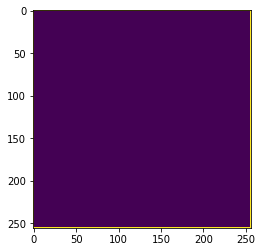

In [26]:
imshow(s2>2)

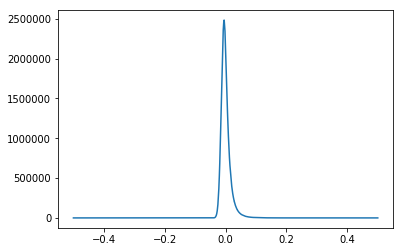

In [8]:
edges = linspace(*bounds,nbins)
plot(edges,counts)